# 1. Import Libraries and Set Directory
---

Import Libraries

In [10]:
is_drive = 0

In [11]:
if is_drive==1 :
    from google.colab import drive
    drive.mount('/content/drive')

In [12]:
# directory management
import os
from glob import glob
# regular imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# audio analysis
import librosa 
import librosa.display
import IPython.display as ipd
# imports for colors and plots
from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
# imports for NN
import tensorflow as tf
from tensorflow import keras
import time

# 2. Draw Graphs of 1 File
---

a function that returns audio in numeric representation

Read all audio files and sort

In [13]:
if is_drive==1 :
  train_audio_dir = glob('/content/drive/MyDrive/audio-dataset/Train/*.wav')
else :
  train_audio_dir = glob('../Project/audio-dataset/Train/*.wav')

In [14]:
# Play audio file
ipd.Audio(train_audio_dir[0])

In [15]:
FRAME_SIZE = 1600
HOP_LENGTH = 412
DURATION = 0.8  # in seconds
SAMPLE_RATE = 16000
MONO = True

In [16]:
# check values and sample rate
y, sr = librosa.load(train_audio_dir[0],
                    sr=SAMPLE_RATE,
                    duration=DURATION,
                    mono=MONO)
print(f'Amplitude: {y[:4]}')
print(f'Amplitude shape: {y.shape}')
print(f'Sample Rate: {sr}')

Amplitude: [ 3.0517578e-05 -2.4414062e-04 -1.2207031e-04 -3.0517578e-04]
Amplitude shape: (12800,)
Sample Rate: 16000


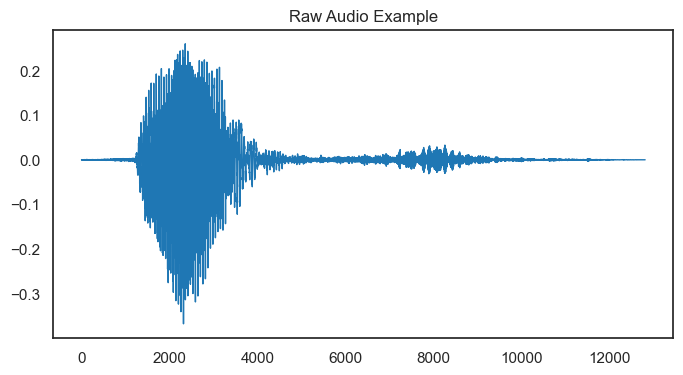

In [17]:
pd.Series(y).plot(figsize=(8, 4),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

## Spectogram

In [18]:
# Short Time Fourier Transform
stft = librosa.stft(y,
                    n_fft=FRAME_SIZE,
                    hop_length=HOP_LENGTH)[:-1]
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)
log_spectrogram.shape

(800, 32)

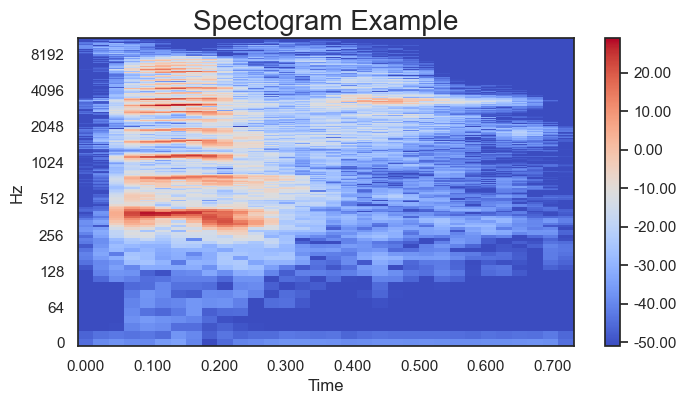

In [19]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(8,4))
img = librosa.display.specshow(log_spectrogram,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# 3. Load Dataset and Training the Models
---

## 3.1. Loading Spectograms

In [20]:
# Spectogram Path
if is_drive==1 :   
    TRAIN_DIR = "/content/drive/MyDrive/spectogram-dataset/Train/"
    TEST_DIR = "/content/drive/MyDrive/spectogram-dataset/Test/"
else :
    TRAIN_DIR = "../Project/spectogram-dataset/Train/"
    TEST_DIR = "../Project/spectogram-dataset/Test/"

In [21]:
def load_fsdd(train_spectrograms_path,test_spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(train_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_train.append(spectrogram)
    x_train = np.array(x_train)        # -> (n_samples, n_bins, n_frames)
    x_train = x_train[..., np.newaxis] # -> (1200, 800, 32, 1)

    x_test  = []
    for root, _, file_names in os.walk(test_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_test.append(spectrogram)
    x_test = np.array(x_test)        # -> (n_samples, n_bins, n_frames)
    x_test = x_test[..., np.newaxis] # -> (300, 800, 32, 1)

    return x_train,x_test

In [22]:
x_train, x_test = load_fsdd(TRAIN_DIR, TEST_DIR)

## 3.2 Simple Flatten AE

In [23]:
from keras import layers

In [24]:
BATCH_SIZE = 32
EPOCHS = 15
print(x_train.shape)
print(x_test.shape)
# flatten the dataset
x_train_sm = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sm  = x_test .reshape((len(x_test ), np.prod(x_test .shape[1:])))
print(x_train_sm.shape)
print(x_test_sm.shape)

(1200, 800, 32, 1)
(300, 800, 32, 1)
(1200, 25600)
(300, 25600)


In [25]:
# the size of compression dimension
encoding_dim = 32
#input image
input_img = keras.Input(shape=(25600,))
#encoded representation of the input
encoded = layers.Dense(encoding_dim,activation='relu')(input_img)
# lossy reconstruction
decoded = layers.Dense(25600, activation="sigmoid")(encoded)

simple_ae = keras.Model(inputs=input_img, outputs=decoded)

simple_ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25600)]           0         
                                                                 
 dense (Dense)               (None, 32)                819232    
                                                                 
 dense_1 (Dense)             (None, 25600)             844800    
                                                                 
Total params: 1,664,032
Trainable params: 1,664,032
Non-trainable params: 0
_________________________________________________________________


In [26]:
simple_ae_encoder = keras.Model(inputs=input_img, outputs=encoded)

In [27]:
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = simple_ae.layers[-1]
simple_ae_decoder = keras.Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [28]:
simple_ae.compile(optimizer='adam', loss='binary_crossentropy')

In [29]:
tic=time.time()
with tf.device('/GPU:1'):
    hist = simple_ae.fit( x_train_sm,x_train_sm,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        validation_data=(x_test_sm,x_test_sm))
toc=time.time()
training_time=toc-tic

Epoch 1/15
38/38 [==============================] - 5s 73ms/step - loss: 0.5010 - val_loss: 0.4614
Epoch 2/15
38/38 [==============================] - 3s 71ms/step - loss: 0.4357 - val_loss: 0.4452
Epoch 3/15
38/38 [==============================] - 3s 68ms/step - loss: 0.4239 - val_loss: 0.4414
Epoch 4/15
38/38 [==============================] - 3s 72ms/step - loss: 0.4202 - val_loss: 0.4401
Epoch 5/15
38/38 [==============================] - 3s 66ms/step - loss: 0.4175 - val_loss: 0.4376
Epoch 6/15
38/38 [==============================] - 3s 71ms/step - loss: 0.4144 - val_loss: 0.4367
Epoch 7/15
38/38 [==============================] - 3s 71ms/step - loss: 0.4120 - val_loss: 0.4343
Epoch 8/15
38/38 [==============================] - 3s 67ms/step - loss: 0.4101 - val_loss: 0.4328
Epoch 9/15
38/38 [==============================] - 3s 75ms/step - loss: 0.4083 - val_loss: 0.4324
Epoch 10/15
38/38 [==============================] - 3s 73ms/step - loss: 0.4068 - val_loss: 0.4303
Epoch 11/

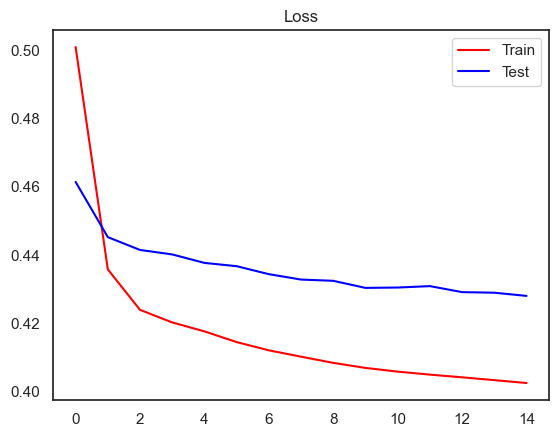

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.show()